# Random walk

In [1]:
import sys
import numpy as np
import corner
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging

from goldmine.simulators.random_walk_checkpointed import CheckpointedRandomWalk
from goldmine.inference.scandal_checkpointed import CheckpointedSCANDALInference

In [2]:
logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')
logging.getLogger().setLevel(logging.INFO)

In [3]:
def ccolor(val, vmin, vmax, cmap='viridis'):
    cmap = matplotlib.cm.get_cmap(cmap)
    return cmap((val - vmin) / (vmax - vmin)).reshape(-1,)

## Settings

In [4]:
n_sim = 1000
n_plot = 20

theta0 = 80.
theta1 = 150.

## Simulate random walk

In [5]:
sim = CheckpointedRandomWalk()
x0, t_xz0, z_checkpoints0, t_xz_checkpoints0, z0 = sim.rvs_score([theta0], [100.], n_sim, return_histories=True)
x1, t_xz1, z_checkpoints1, t_xz_checkpoints1, z1 = sim.rvs_score([theta1], [100.], n_sim, return_histories=True)

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


## Train SCANDAL

In [11]:
inf0 = CheckpointedSCANDALInference(
    n_parameters=1,
    n_observables=1,
    n_latent=1,
    n_components=1,
    n_mades=1,
    n_made_hidden_layers=1,
    n_made_units_per_layer=20,
    activation='relu',
    batch_norm=False,
    n_step_hidden_layers=1,
    n_step_units_per_layer=20,
    step_activation='relu'
)

inf0.fit(
    theta=theta0 * np.ones_like(t_xz0),
    x=x0,
    t_xz=t_xz0,
    t_xz_checkpoints=t_xz_checkpoints0,
    z_checkpoints=z_checkpoints0,
    alpha=1.,
    beta=1000.,
    validation_split=None,
)

15:51  Initialized checkpointed NDE (MAF) with the following settings:
15:51    Parameters:        1
15:51    Observables:       1
15:51    Latent vars:       1
15:51    Checkpoint score estimator:
15:51      Hidden layers:   1
15:51      Units:           20
15:51      Activation:      relu
15:51    Global flow:
15:51      Base components: 1
15:51      MADEs:           1
15:51      Hidden layers:   1
15:51      Units:           20
15:51      Activation:      relu
15:51      Batch norm:      False
15:51  Training checkpointed SCANDAL with settings:
15:51    alpha:                  1.0
15:51    beta:                   1000.0
15:51    theta given:            True
15:51    theta1 given:           False
15:51    x given:                True
15:51    y given:                False
15:51    r_xz given:             False
15:51    t_xz given:             True
15:51    z_checkpoints given:    True
15:51    r_xz_checkpoints given: False
15:51    t_xz_checkpoints given: True
15:51    Samples:      

In [12]:
t_x0 = inf0.predict_score(
    theta=theta0 * np.ones_like(t_xz0),
    x=x0
)

In [14]:
t_xzcp0 = inf0.predict_score_conditional_on_checkpoints(
    theta=theta0 * np.ones_like(t_xz0),
    z_checkpoints=z_checkpoints0
)

## Plot random walks

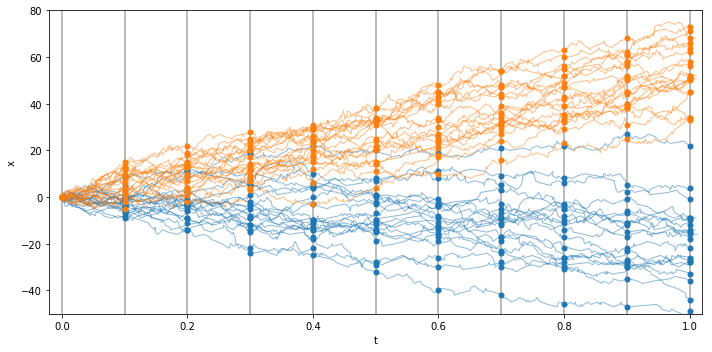

In [15]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -50, 80

fig = plt.figure(figsize=(10,5))

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Trajectories from theta0
for z in z0[:n_plot]:
    plt.plot(
        np.array(z)[:,0], np.array(z)[:,1],
        ls='-',c='C0', lw=1., alpha=0.5
    )
    
# Trajectories from theta1
for z in z1[:n_plot]:
    plt.plot(
        np.array(z)[:,0], np.array(z)[:,1],
        ls='-', c='C1',lw=1., alpha=0.5
    )
    
# Checkpoints from theta0
for z in z_checkpoints0[:n_plot]:
    plt.plot(
        checkpoints, z,
        marker='o', ms=5., ls=' ', c='C0', alpha=1.
    )
    
# Checkpoints from theta1
for z in z_checkpoints1[:n_plot]:
    plt.plot(
        checkpoints, z,
        marker='o', ms=5., ls=' ', c='C1', alpha=1.
    )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')
    
plt.tight_layout()
plt.show()

## Plot joint scores

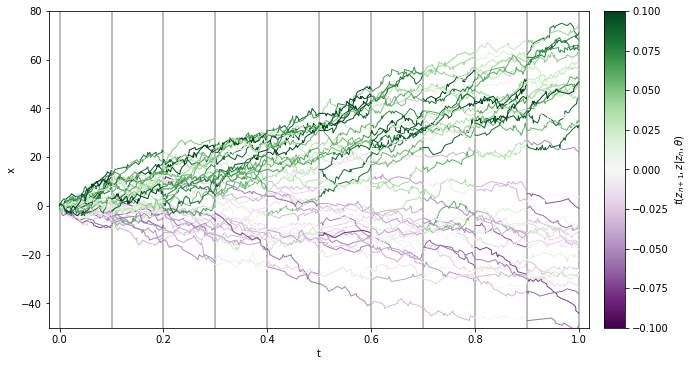

In [18]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -50, 80
vmax = 0.1

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.08, 0.75, 0.88])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, z_cp, t_xz in zip(z0[:n_plot], z_checkpoints0[:n_plot], t_xz_checkpoints0[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([z_cp[i], x_, z_cp[i+1]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_xz[i+1], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
# Joint scores for theta1 trajectories
for z, z_cp, t_xz in zip(z1[:n_plot], z_checkpoints1[:n_plot], t_xz_checkpoints1[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([z_cp[i], x_, z_cp[i+1]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_xz[i+1], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.08, 0.03, 0.88])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$t(z_{n+1}, z | z_n, \theta)$')
    
plt.savefig('random_walk_joint_score.pdf')
plt.show()

## Plot estimated checkpoint scores

In [20]:
t_xzcp0.shape

(1000, 1)

IndexError: index 1 is out of bounds for axis 0 with size 1

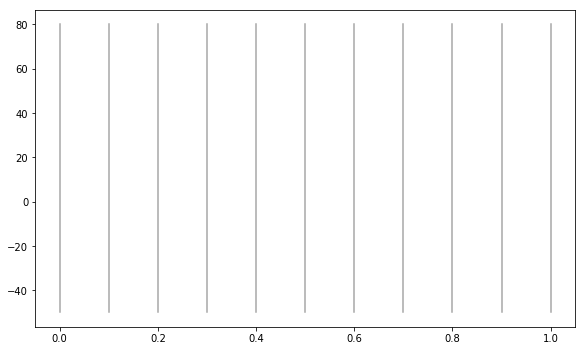

In [19]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -50, 80
vmax = 0.1

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.08, 0.75, 0.88])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, z_cp, t_xz in zip(z0[:n_plot], z_checkpoints0[:n_plot], t_xzcp0[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([z_cp[i], x_, z_cp[i+1]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_xz[i+1], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.08, 0.03, 0.88])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(z_{n+1}| z_n, \theta)$')
    
plt.savefig('random_walk_checkpoint_score.pdf')
plt.show()

## Plot estimated overall score

In [ ]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -50, 80
vmax = 0.1

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.08, 0.75, 0.88])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, z_cp, t_x in zip(z0[:n_plot], z_checkpoints0[:n_plot], t_x0[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([[z_cp[i]], x_, [z_cp[i+1]]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_x, -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.08, 0.03, 0.88])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(z_{n+1}| z_n, \theta)$')
    
plt.savefig('random_walk_score.pdf')
plt.show()